In [1]:
import sys
import numpy as np
import cv2
import cv2.ml
from time import sleep
import pytz
from datetime import datetime
from pysolar import solar
import os
import numpy as np
from random import shuffle
from matplotlib import pyplot as plt
import matplotlib as mpl
from pandas import read_csv, read_excel, DataFrame
from skimage.feature import hessian_matrix_det as Hessian
from skimage.feature import local_binary_pattern as LBP
import pickle
import logging
logging.basicConfig(level=logging.INFO)

p0 = os.path.join('../../','raw','CookIRCamET','Images','CookHY2023')
p1 = os.path.join('../../','work','CookIRCamET','Images','CookHY2023','RGB')
p2 = os.path.join('../../','work','CookIRCamET','Images','CookHY2023','Labels')
p00 = os.path.join('../../','raw','CookIRCamET','Images','CprlHY2023')
p11 = os.path.join('../../','work','CookIRCamET','Images','CprlHY2023','RGB')
p22 = os.path.join('../../','work','CookIRCamET','Images','CprlHY2023','Labels')
p3 = os.path.join('../../','work','CookIRCamET','Working')
n_components1 = 2
n_components2 = 4
n_components3 = 8


# In[2]:


cmap1 = mpl.colors.ListedColormap(['y', 'b'])
norm1 = mpl.colors.BoundaryNorm([0,1], cmap1.N)

cmap2 = mpl.colors.ListedColormap(['r', 'b', 'g','w'])
norm2 = mpl.colors.BoundaryNorm([0,1,2,3,4], cmap2.N)


# In[3]:


def localSD(mat, n):    
    mat=np.float32(mat)
    mu = cv2.blur(mat,(n,n))
    mdiff=mu-mat
    mat2=cv2.blur(np.float64(mdiff*mdiff),(n,n))
    sd = np.float32(cv2.sqrt(mat2))
    
    return sd


model_mlp1 = pickle.load(open(os.path.join(p3,'finalized_model1.pk.sav'), 'rb'))
model_mlp2 = pickle.load(open(os.path.join(p3,'finalized_model2.pk.sav'), 'rb'))
scaler = pickle.load(open(os.path.join(p3,'scaler.pk.sav'), 'rb'))

In [ ]:
f_imgs=[]
imgs=[]
f_sol_sun = []
f_sol_shd = []
f_res_sun = []
f_res_shd = []
f_veg_sun = []
f_veg_shd = []
f_snw_sun = []
f_snw_shd = []

elevation = []
azimuth = []

times = []

n_img=0

lat = np.nan
lon = np.nan
for di,do in zip([p1,p11],[p2,p22]):
    fs=os.listdir(di)
  
    for f in fs:
        if 'bgr' in f:
            f_imgs = np.append(f_imgs,f)
            bgr = cv2.imread(os.path.join(di,f),cv2.IMREAD_UNCHANGED)
            #filter nighttime
            #20221017084722_-117.081903_46.781495_bgr.png
            time_place = f.split('_bgr.')[0].split('_')
            if len(time_place)==3 or 'nofix' in f:#V1
                utc = pytz.utc.localize(datetime.strptime(time_place[0], '%Y%m%d%H%M%S'))
                theta = np.nan
                phi = np.nan
                if 'nofix' not in time_place:
                    lat = np.double(time_place[2])
                    lon = np.double(time_place[1])
                elif 'nofix' in time_place and di==p00:
                    #Latitude: 35 ° 11’ 17.45”; Longitude: 102° 5’ 43.98”; elevation : 1168 m
                    lat = 35+11/60+17.45/3600
                    lon = -(102+5/60+43.98/3600)
                else:
                    pass
                print(utc,lat,lon)
                theta = solar.get_altitude(lat,lon,utc)
                phi = solar.get_azimuth(lat,lon,utc)
                print(theta,phi)
                if theta>10.0:
    
                    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
                    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
                    img = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
                    l,a,bb = cv2.split(lab)
                    h,s,v = cv2.split(hsv)

                    sd_l1 = localSD(l, 127)
                    sd_l2 = localSD(l, 63)
                    sd_l3 = localSD(l, 31)

                    lbp_l1 = LBP(l, 32, 4, method='ror')
                    lbp_l2 = LBP(l, 24, 3, method='ror')
                    lbp_l3 = LBP(l, 16, 2, method='ror')

                    sd_a1 = localSD(a, 127)
                    sd_a2 = localSD(a, 63)
                    sd_a3 = localSD(a, 31)

                    lbp_a1 = LBP(a, 32, 4, method='ror')
                    lbp_a2 = LBP(a, 24, 3, method='ror')
                    lbp_a3 = LBP(a, 16, 2, method='ror')

                    sd_b1 = localSD(bb, 127)
                    sd_b2 = localSD(bb, 63)
                    sd_b3 = localSD(bb, 31)

                    lbp_b1 = LBP(bb, 32, 4, method='ror')
                    lbp_b2 = LBP(bb, 24, 3, method='ror')
                    lbp_b3 = LBP(bb, 16, 2, method='ror')

                    sd_h1 = localSD(h, 127)
                    sd_h2 = localSD(h, 63)
                    sd_h3 = localSD(h, 31)

                    lbp_h1 = LBP(h, 32, 4, method='ror')
                    lbp_h2 = LBP(h, 24, 3, method='ror')
                    lbp_h3 = LBP(h, 16, 2, method='ror')

                    sd_s1 = localSD(s, 127)
                    sd_s2 = localSD(s, 63)
                    sd_s3 = localSD(s, 31)

                    lbp_s1 = LBP(s, 32, 4, method='ror')
                    lbp_s2 = LBP(s, 24, 3, method='ror')
                    lbp_s3 = LBP(s, 16, 2, method='ror')

                    sd_v1 = localSD(v, 127)
                    sd_v2 = localSD(v, 63)
                    sd_v3 = localSD(v, 31)

                    lbp_v1 = LBP(v, 32, 4, method='ror')
                    lbp_v2 = LBP(v, 24, 3, method='ror')
                    lbp_v3 = LBP(v, 16, 2, method='ror')

                    ddepth = cv2.CV_16S

                    lap_l1 = cv2.Laplacian(l,ddepth,ksize=3)
                    lap_l2 = cv2.Laplacian(l,ddepth,ksize=7)
                    lap_l3 = cv2.Laplacian(l,ddepth,ksize=15)

                    lap_a1 = cv2.Laplacian(a,ddepth,ksize=3)
                    lap_a2 = cv2.Laplacian(a,ddepth,ksize=7)
                    lap_a3 = cv2.Laplacian(a,ddepth,ksize=15)

                    lap_b1 = cv2.Laplacian(bb,ddepth,ksize=3)
                    lap_b2 = cv2.Laplacian(bb,ddepth,ksize=7)
                    lap_b3 = cv2.Laplacian(bb,ddepth,ksize=15)

                    lap_h1 = cv2.Laplacian(h,ddepth,ksize=3)
                    lap_h2 = cv2.Laplacian(h,ddepth,ksize=7)
                    lap_h3 = cv2.Laplacian(h,ddepth,ksize=15)

                    lap_s1 = cv2.Laplacian(s,ddepth,ksize=3)
                    lap_s2 = cv2.Laplacian(s,ddepth,ksize=7)
                    lap_s3 = cv2.Laplacian(s,ddepth,ksize=15)

                    lap_v1 = cv2.Laplacian(v,ddepth,ksize=3)
                    lap_v2 = cv2.Laplacian(v,ddepth,ksize=7)
                    lap_v3 = cv2.Laplacian(v,ddepth,ksize=15)

                    img_size = l.shape
                    bb = bb.ravel()
                    a = a.ravel()
                    l = l.ravel()
                    h = h.ravel()
                    s = s.ravel()
                    v = v.ravel()
                    sd_l1 = sd_l1.ravel()
                    sd_l2 = sd_l2.ravel()
                    sd_l3 = sd_l3.ravel()
                    lbp_l1 = lbp_l1.ravel()
                    lbp_l2 = lbp_l2.ravel()
                    lbp_l3 = lbp_l3.ravel()
                    lap_l1 = lap_l1.ravel()
                    lap_l2 = lap_l2.ravel()
                    lap_l3 = lap_l3.ravel()
                    sd_a1 = sd_a1.ravel()
                    sd_a2 = sd_a2.ravel()
                    sd_a3 = sd_a3.ravel()
                    lbp_a1 = lbp_a1.ravel()
                    lbp_a2 = lbp_a2.ravel()
                    lbp_a3 = lbp_a3.ravel()
                    lap_a1 = lap_a1.ravel()
                    lap_a2 = lap_a2.ravel()
                    lap_a3 = lap_a3.ravel()
                    sd_b1 = sd_b1.ravel()
                    sd_b2 = sd_b2.ravel()
                    sd_b3 = sd_b3.ravel()
                    lbp_b1 = lbp_b1.ravel()
                    lbp_b2 = lbp_b2.ravel()
                    lbp_b3 = lbp_b3.ravel()
                    lap_b1 = lap_b1.ravel()
                    lap_b2 = lap_b2.ravel()
                    lap_b3 = lap_b3.ravel()
                    sd_h1 = sd_h1.ravel()
                    sd_h2 = sd_h2.ravel()
                    sd_h3 = sd_h3.ravel()
                    lbp_h1 = lbp_h1.ravel()
                    lbp_h2 = lbp_h2.ravel()
                    lbp_h3 = lbp_h3.ravel()
                    lap_h1 = lap_h1.ravel()
                    lap_h2 = lap_h2.ravel()
                    lap_h3 = lap_h3.ravel()
                    sd_s1 = sd_s1.ravel()
                    sd_s2 = sd_s2.ravel()
                    sd_s3 = sd_s3.ravel()
                    lbp_s1 = lbp_s1.ravel()
                    lbp_s2 = lbp_s2.ravel()
                    lbp_s3 = lbp_s3.ravel()
                    lap_s1 = lap_s1.ravel()
                    lap_s2 = lap_s2.ravel()
                    lap_s3 = lap_s3.ravel()
                    sd_v1 = sd_v1.ravel()
                    sd_v2 = sd_v2.ravel()
                    sd_v3 = sd_v3.ravel()
                    lbp_v1 = lbp_v1.ravel()
                    lbp_v2 = lbp_v2.ravel()
                    lbp_v3 = lbp_v3.ravel()
                    lap_v1 = lap_v1.ravel()
                    lap_v2 = lap_v2.ravel()
                    lap_v3 = lap_v3.ravel()
                    sd_h3[np.isnan(sd_h3)]=np.nanmean(sd_h3)
                    feat = np.vstack((l.T,a.T,bb.T,h.T,s.T,v.T,
                                      sd_l1.T,sd_l2.T,sd_l3.T,
                                      lbp_l1.T,lbp_l2.T,lbp_l3.T,
                                      lap_l1.T,lap_l2.T,lap_l3.T,
                                      sd_a1.T,sd_a2.T,sd_a3.T,
                                      lbp_a1.T,lbp_a2.T,lbp_a3.T,
                                      lap_a1.T,lap_a2.T,lap_a3.T,
                                      sd_b1.T,sd_b2.T,sd_b3.T,
                                      lbp_b1.T,lbp_b2.T,lbp_b3.T,
                                      lap_b1.T,lap_b2.T,lap_b3.T,
                                      sd_h1.T,sd_h2.T,sd_h3.T,
                                      lbp_h1.T,lbp_h2.T,lbp_h3.T,
                                      lap_h1.T,lap_h2.T,lap_h3.T,
                                      sd_s1.T,sd_s2.T,sd_s3.T,
                                      lbp_s1.T,lbp_s2.T,lbp_s3.T,
                                      lap_s1.T,lap_s2.T,lap_s3.T,
                                      sd_v1.T,sd_v2.T,sd_v3.T,
                                      lbp_v1.T,lbp_v2.T,lbp_v3.T,
                                      lap_v1.T,lap_v2.T,lap_v3.T)).T
                    
                    feat = scaler.transform(feat)

                    pred_mlp1 = model_mlp1.predict(feat).reshape(bgr.shape[0:2])
                    pred_mlp2 = model_mlp2.predict(feat).reshape(bgr.shape[0:2])

                    plt.imshow(bgr)
                    plt.show()
                    plt.imshow(pred_mlp1, cmap=cmap1, norm=norm1, interpolation='none')
                    plt.show()
                    plt.imshow(pred_mlp2, cmap=cmap2, norm=norm2, interpolation='none')
                    plt.show()

                    f_sol_sun.append(np.sum((pred_mlp1==0) & (pred_mlp2==0)))
                    f_sol_shd.append(np.sum((pred_mlp1==1) & (pred_mlp2==0)))
                    f_res_sun.append(np.sum((pred_mlp1==0) & (pred_mlp2==1)))
                    f_res_shd.append(np.sum((pred_mlp1==1) & (pred_mlp2==1)))
                    f_veg_sun.append(np.sum((pred_mlp1==0) & (pred_mlp2==2)))
                    f_veg_shd.append(np.sum((pred_mlp1==1) & (pred_mlp2==2)))
                    f_snw_sun.append(np.sum((pred_mlp1==0) & (pred_mlp2==3)))
                    f_snw_shd.append(np.sum((pred_mlp1==1) & (pred_mlp2==3)))
                else:
                    f_sol_sun.append(np.nan)
                    f_sol_shd.append(np.nan)
                    f_res_sun.append(np.nan)
                    f_res_shd.append(np.nan)
                    f_veg_sun.append(np.nan)
                    f_veg_shd.append(np.nan)
                    f_snw_sun.append(np.nan)
                    f_snw_shd.append(np.nan)
                    
                elevation.append(90-theta)
                azimuth.append(phi)

                times.append(utc)

                n_img=n_img+1
df = pd.DataFrame(data={'times':times,'elevation':elevation,'azimuth':azimuth,'fssun':f_sol_sun,'fsshd':f_sol_shd,'frsun':f_res_sun,'frshd':f_res_shd,'fvsun':f_veg_sun,'fvshd':f_veg_shd,'fwsun':f_snw_sun,'fwshd':f_snw_shd})
df.to_csv(os.path.join(p3,'output.csv'))

In [ ]:
plt.imshow(np.reshape(h,(bgr.shape[0:2])))





In [13]:
np.argwhere(np.isnan(feat))

feat.shape




(1228800, 60)

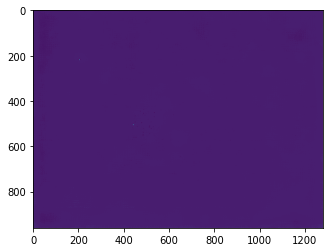

In [26]:
plt.imshow(h.reshape(img.shape[0:2]))


In [35]:
np.nanmean(sd_h3)

0.4303129

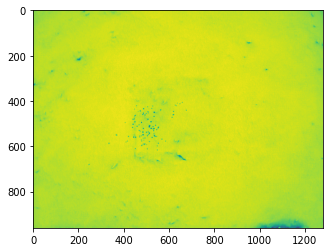

In [27]:
plt.imshow(img)